Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

For this project we are going to analyze a dataset of car sales for a new app.  The goal is to attempt to predict the sale cost of the vehicle based off a wide range of variables (model, mileage, trim, etc.).  First the data needs to be prepared, there are columns with blank values and missing information.  Then we need to split the data into training and test sets.  From there we will run models on the data to see which ones best predicts the price.  We are going to use LinearRegression as a sanity check and use random forest and decision tree models with hyperparameter tuning and then add gradient boosting to see which performs the best for model prediciton.

In [1]:
import pandas as pd
import numpy as np
import math

cars = pd.read_csv('/datasets/car_data.csv')

print(cars.describe())
print()
print(cars.head(10))
print()
print(cars.info())

               Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.

In [2]:
import re

def lowercase_u(name):
    return re.sub(r'([a-z])([A-Z])', r'\1_\2', name).lower()

cars.columns = [lowercase_u(col) for col in cars.columns]

print(cars.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

First I am going to put underscores between words and make all columns lowercase.

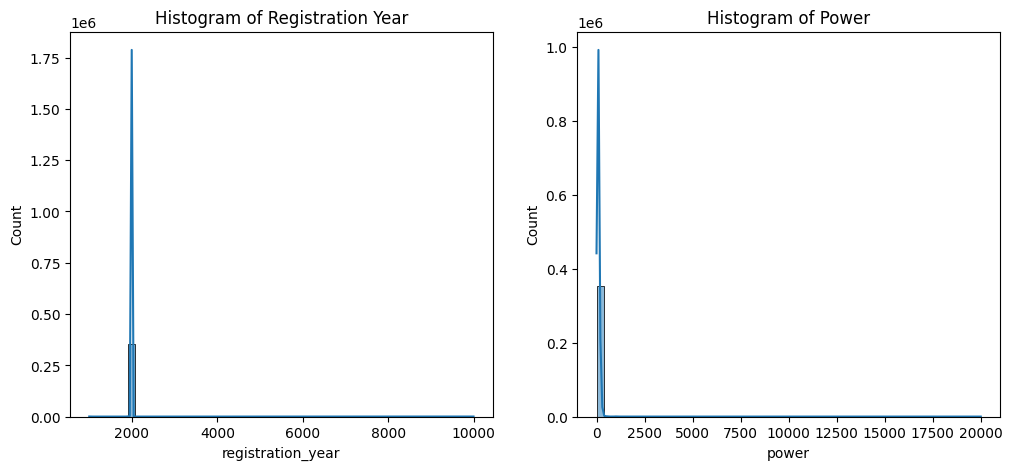

Potential outliers:
         registration_year  power
7                    1980     50
15                   1910      0
28                   1981     50
39                   1984     70
41                   2002    306
...                   ...    ...
354302               1984      0
354306               2008    269
354316               1957     40
354337               2004    445
354354               2003    260

[13499 rows x 2 columns]


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(cars["registration_year"], bins=50, kde=True)
plt.title("Histogram of Registration Year")

plt.subplot(1, 2, 2)
sns.histplot(cars["power"], bins=50, kde=True)
plt.title("Histogram of Power")

plt.show()

Q1 = cars[["registration_year", "power"]].quantile(0.25)
Q3 = cars[["registration_year", "power"]].quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (cars < (Q1 - 1.5 * IQR)) | (cars > (Q3 + 1.5 * IQR))
outliers = cars[outlier_mask.any(axis=1)]

print("Potential outliers:\n", outliers[["registration_year", "power"]])

The registration year and power data have variables that do not make any sense.  There is registration years past the current year and before 1950 which are impossible and extremely unlikely.  Since all of the data is from 2016 I am going to remove rows after 2016 and before 1950.  For Power since even a golf cart usually has 5 HP and most cars do not have horsepower over several hundred I am going to remove all values outside of the range for both of them.

In [4]:
cars = cars[(cars["registration_year"] >= 1950) & (cars["registration_year"] <= 2017)]
cars = cars[(cars["power"] >= 5) & (cars["power"] <= 700)]

print(cars.info())
print(cars.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310632 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        310632 non-null  object
 1   price               310632 non-null  int64 
 2   vehicle_type        290868 non-null  object
 3   registration_year   310632 non-null  int64 
 4   gearbox             304369 non-null  object
 5   power               310632 non-null  int64 
 6   model               297731 non-null  object
 7   mileage             310632 non-null  int64 
 8   registration_month  310632 non-null  int64 
 9   fuel_type           290777 non-null  object
 10  brand               310632 non-null  object
 11  not_repaired        262177 non-null  object
 12  date_created        310632 non-null  object
 13  number_of_pictures  310632 non-null  int64 
 14  postal_code         310632 non-null  int64 
 15  last_seen           310632 non-null  object
dtypes:

In [5]:
nan_counts = cars.isna().sum()
print(nan_counts)

date_crawled              0
price                     0
vehicle_type          19764
registration_year         0
gearbox                6263
power                     0
model                 12901
mileage                   0
registration_month        0
fuel_type             19855
brand                     0
not_repaired          48455
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64


#A large amount of missing values occur in 5 different rows.  Vehicle type, gearbox, model, fuel type and not repaired all contain tens of thousands of missing values.  Since vehicle type, gearbox, model and fuel type are all categorical features that cannot switched to 0 or to the mean of the data set I am going to drop those columns from the dataset.  For not repaired since the answer is Yes/No I am going to assume the one with blanks are 'No' and adjust there values.

In [6]:
cars[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'registration_month', 'number_of_pictures', 'not_repaired']] = cars[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'registration_month', 'number_of_pictures', 'not_repaired']].fillna('Unknown')

nan_counts = cars.isna().sum()
print(nan_counts)

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64


#A few of the columns I do not feel are needed and are just going to take up space and cause models to run longer.  Registration month does not really give us any additional information and we already have registration year which is far more important so I will be dropping the month column.  Number of pictures is a 0 value for every single row, it gives us no details and I will be dropping it as well.  Last seen, date create and date crawled all have various formats of date date in their columns so I will be reformatting them to match as well.

In [7]:
columns_to_drop = ['registration_month', 'number_of_pictures', 'date_crawled', 'date_created', 'last_seen']
cars = cars.drop(columns=columns_to_drop)

print(cars.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 310632 entries, 1 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              310632 non-null  int64 
 1   vehicle_type       310632 non-null  object
 2   registration_year  310632 non-null  int64 
 3   gearbox            310632 non-null  object
 4   power              310632 non-null  int64 
 5   model              310632 non-null  object
 6   mileage            310632 non-null  int64 
 7   fuel_type          310632 non-null  object
 8   brand              310632 non-null  object
 9   not_repaired       310632 non-null  object
 10  postal_code        310632 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 28.4+ MB
None


#Next I want to see how many unique variables each of the categorical columns have to get an idea of what type of encoding I should use.

In [8]:
categorical_columns = cars.select_dtypes(include=['object'])
unique_counts = categorical_columns.nunique()
print(unique_counts)

vehicle_type      9
gearbox           3
model           250
fuel_type         8
brand            40
not_repaired      3
dtype: int64


##IGNORE NOW #I will be using OneHotEncoding for vehicle type and fuel type since this is best for low cardinality features and good for decision trees.  Both of these have fewer than 10 features.  For gearbox and not_repaired I will be using binary coding changing the value to either 1 or 0 since there is only 2 options.  For model and brand I will use target encoding since there are so many unique values and OneHotEncoding would create to many columns.

#Now that I have encoded the data I can proceed with my various model trainings.

## Model training

In [9]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
import numpy as np

#Splitting the data into features and target variables using a test size of 0.3.  
#Encoding the data using OneHotEncoder for categorical features to run on linear regression models

features = cars.drop(['price'], axis=1)
target = cars['price']

categorical_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
numerical_features = ['registration_year', 'power', 'mileage', 'postal_code']



features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'  # Keeps other columns as they are
)

features_train_transformed = preprocessor.fit_transform(features_train)
features_test_transformed = preprocessor.transform(features_test)

In [11]:
#Linear Regression Model Training
model = LinearRegression()

%time model.fit(features_train_transformed, target_train)
%time pred_train = model.predict(features_train_transformed)
%time pred_test = model.predict(features_test_transformed)
print(f"RMSE for target data:", mean_squared_error(target_test, pred_test, squared=False).round(2))
print(f"RMSE for training data:", mean_squared_error(target_train, pred_train, squared=False).round(2))


CPU times: user 2.76 s, sys: 5.34 s, total: 8.1 s
Wall time: 8.03 s
CPU times: user 1.57 ms, sys: 10.1 ms, total: 11.7 ms
Wall time: 2.93 ms
CPU times: user 2.68 ms, sys: 3.22 ms, total: 5.91 ms
Wall time: 1.54 ms
RMSE for target data: 2660.18
RMSE for training data: 2641.69


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.preprocessing import OrdinalEncoder
import time

# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features)
encoder = OrdinalEncoder()

features[categorical_features] = encoder.fit_transform(features[categorical_features])

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.3, random_state=12345
)

lgbm = LGBMRegressor(boosting_type='rf', random_state=12345, n_jobs=-1)

param_grid = {'n_estimators': [100, 250], 'max_depth': [10, 20], "bagging_freq": [5], "bagging_fraction": [0.8]}

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
final_model = LGBMRegressor(**best_params, boosting_type='rf', n_jobs=-1)
print("Best parameter model time:")
%time final_model.fit(features_train, target_train)
best_model = grid_search.best_estimator_
print("Prediction model time:")
%time y_pred_lgbrf = best_model.predict(features_test)

rmse_lgbrf = np.sqrt(mean_squared_error(target_test, y_pred_lgbrf))

print(f"Best Parameters: {grid_search.best_params_}")
print(f"LightGBM Random Forest RMSE (Tuned): {rmse_lgbrf:.2f}")

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagg

In [16]:
from catboost import CatBoostRegressor

catboost_model =  CatBoostRegressor(random_seed=12345, silent=True)

param_grid = {'iterations': [100, 500], 'depth': [6, 10], 'learning_rate': [0.01, 0.1]}
grid_search = GridSearchCV(estimator=catboost_model, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(features_train, target_train)

best_params = grid_search.best_params_
final_model = CatBoostRegressor(**best_params, random_seed=12345, silent=True)
print("Best parameter model time:")
%time final_model.fit(features_train, target_train)

best_model_cbrf = grid_search.best_estimator_
print("Prediction Model Time:")
%time y_pred_cbrf = best_model_cbrf.predict(features_test)

rmse_cbrf = np.sqrt(mean_squared_error(target_test, y_pred_cbrf))
print(f"Best Parameters Catboost: {grid_search.best_params_}")
print(f"Catboost Random Forest RMSE (Tuned): {rmse_cbrf:.2f}")

Best parameter model time:
CPU times: user 26.4 s, sys: 40.9 ms, total: 26.4 s
Wall time: 26.5 s
Prediction Model Time:
CPU times: user 102 ms, sys: 12 µs, total: 102 ms
Wall time: 102 ms
Best Parameters Catboost: {'depth': 10, 'iterations': 500, 'learning_rate': 0.1}
Catboost Random Forest RMSE (Tuned): 1673.65


In [19]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=12345)

param_grid_xgb = {'learning_rate': [0.01, 0.1], 'max_depth': [10]}

grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_xgb.fit(features_train, target_train)

best_params = grid_search.best_params_
final_model = XGBRegressor(**best_params, objective='reg:squarederror', random_state=12345)
print("Best parameter model time:")
%time final_model.fit(features_train, target_train)

best_xgb = grid_search_xgb.best_estimator_
print("Prediction model time:")
%time y_pred_xgb = best_xgb.predict(features_test)

rmse_xgb = np.sqrt(mean_squared_error(target_test, y_pred_xgb))

print(f"Best XGBoost Parameters: {grid_search_xgb.best_params_}")
print(f"XGBoost RMSE: {rmse_xgb:.4f}")

Best parameter model time:
[17:20:59] WARNING: ../src/learner.cc:576: 
Parameters: { "depth", "iterations" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


CPU times: user 33.8 s, sys: 35.7 ms, total: 33.9 s
Wall time: 33.9 s
Prediction model time:
CPU times: user 552 ms, sys: 0 ns, total: 552 ms
Wall time: 576 ms
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 10}
XGBoost RMSE: 1656.6378


## Model analysis

After examining the following models: linear regression, Random Forest with LightGBM Boost and CatBoost and Decision Tree with XGBRegressor I discovered the random forest and decision tree models to be more accurate.  I used param grid to adjust hyperparameters for the random forest and decision tree classifiers as well.  With the XGBoost model and Catboost model being the most accurate model with an RMSE of 1657 and 1674, respectively.  The two models were very similar in performance but XGB took longer at a wall time of over 8 minutes while CatBoost was a wall time of 6 minutes and 49 seconds.  For the prediction models it was slightly different the CatBoost model was the fastest with a wall time of 102 milliseconds, 2nd fastest was the LightGBM model with a wall time of 390 milliseconds.  3rd Fastest was XGBoost which had a wall tim eof 488 milliseconds.  All of them run the prediction best model very fast but took significant amount of time on the original run through for checking the best parameters.  Overall the model of choice is the XGB or CatBoost models.  They are the most accurate but XGB took a litte bit more time to run.  RMSE is slightly better with the XGB so I would choose that model.

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [X]  Code is error free
- [X]  The cells with the code have been arranged in order of execution
- [X]  The data has been downloaded and prepared
- [X]  The models have been trained
- [X]  The analysis of speed and quality of the models has been performed